In [113]:
%ls data

sample_submission.csv  submission.csv  test.csv  train.csv


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
df = pd.read_csv("data/train.csv")

In [116]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


### First try - use logistic regression to classify digit 8, not digit 8
is it neccesary to reduce dimensions? Let's try without it.
I'm going to do following steps:
- add new column "is_8" to data with value "1" if it's 8 and "0" if it's not;
- shuffle data
- split data into train and test sets
- with train dataset:
 - prepare feaures, labels, initial weights, learning rate, number of iterations
 - run training
- check predictions on test data

In [117]:
# create column for bias
df['pixel784'] = 1
for i in range(10):
    df['is_%d' % i] = df['label'] == i
    df = df.astype({'is_%d' % i: int})

In [118]:
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [119]:
# 70% of 42000 rows is 29400
train_df = df[:29400]
test_df = df[29400:]

In [120]:
#inital weights
weights = 10*np.random.rand(10, 785)
weights.shape

(10, 785)

In [121]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

In [122]:
def predict(features, weights):
    '''
    Returns 1D array of probabilities
    that the class label == 1
    '''
    z = np.dot(features, weights)
    return sigmoid(z)

In [123]:
def cost_function(features, labels, weights):
    '''
    Returns 1D matrix of predictions
    Cost = ( log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = len(labels)
    
    predictions = predict(features, weights)
    
    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1 - labels)*np.log(1 - predictions)

    #Take the sum of both costs
    cost = class1_cost - class2_cost
    #Take the average cost
    cost = cost.sum()/observations

    return cost

In [124]:
def update_weights(features, labels, weights, lr):
    '''
    Vectorized Gradient Descent
    '''
    N = len(features)

    predictions = predict(features, weights)

    gradient = np.dot(features.T,  predictions - labels)

    # take the average cost derivative for each feature
    gradient /= N

    # multiply the gradient by our learning rate
    gradient *= lr

    # subtract from our weights to minimize cost
    weights -= gradient

    return weights

In [125]:
def train(features, labels, weights, lr, iters):
    cost_history = []

    for i in range(1, iters + 1):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)

        # Log Progress
        if i % 50 == 0:
            print("iter: " + str(i) + " cost: "+str(cost))

    return weights, cost_history

In [126]:
# learning rate and number of iterations
learning_rate = 0.001
# for 29400 rows and 784 features, one iteration takes 0.36 seconds
iterations = 10

outer_iterations = 1000

# trained_weights = list(range(10))
cost_history = list(range(10))
for i in range(outer_iterations):
    batch = train_df.sample(n=640)
    # prepare feaures
    features = batch.loc[:, 'pixel0':'pixel784']
    # normalization, because we know that max value is 254
    features = features / 254.

    # prepare labels
    labels = batch.loc[:, 'is_0':'is_9']
    
    # Log Progress
    if i % 100 == 0:
        print("outer iter: " + str(i))
    
    for j in range(10):
        weights[j], cost_history[j] = train(features, labels['is_%d' % j], weights[j], learning_rate, iterations)
    
    

outer iter: 0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


outer iter: 100
outer iter: 200
outer iter: 300
outer iter: 400
outer iter: 500
outer iter: 600
outer iter: 700
outer iter: 800
outer iter: 900


In [127]:
predictions = predict(test_df.loc[:, 'pixel0':'pixel784'] / 254., weights[4])

In [128]:
def decision_boundary(prob):
    return 1 if prob >= .5 else 0

In [129]:
def classify(preds):
    '''
    input  - N element array of predictions between 0 and 1
    output - N element array of 0s (False) and 1s (True)
    '''
    decision_boundary_v = np.vectorize(decision_boundary)
    return decision_boundary_v(predictions).flatten()

In [130]:
def accuracy(predicted_labels, actual_labels):
    diff = predicted_labels - actual_labels
    return 1.0 - (float(np.count_nonzero(diff)) / len(diff))

In [131]:
predicted_labels = classify(predictions)
actual_labels = test_df.loc[:, 'is_4']

In [132]:
accuracy(predicted_labels, actual_labels)

0.09746031746031747

In [133]:
len(predicted_labels), np.count_nonzero(actual_labels), np.count_nonzero(predicted_labels), np.count_nonzero(predicted_labels*actual_labels)

(12600, 1227, 12599, 1227)

In [134]:
np.count_nonzero(predicted_labels*actual_labels) / np.count_nonzero(actual_labels)

1.0

In [135]:
precision = np.count_nonzero(predicted_labels*actual_labels) / np.count_nonzero(predicted_labels)

In [136]:
recall = np.count_nonzero(predicted_labels*actual_labels) / np.count_nonzero(actual_labels)

In [137]:
f1 = 2*precision*recall/(precision + recall)

In [138]:
f1

0.17749168233762477

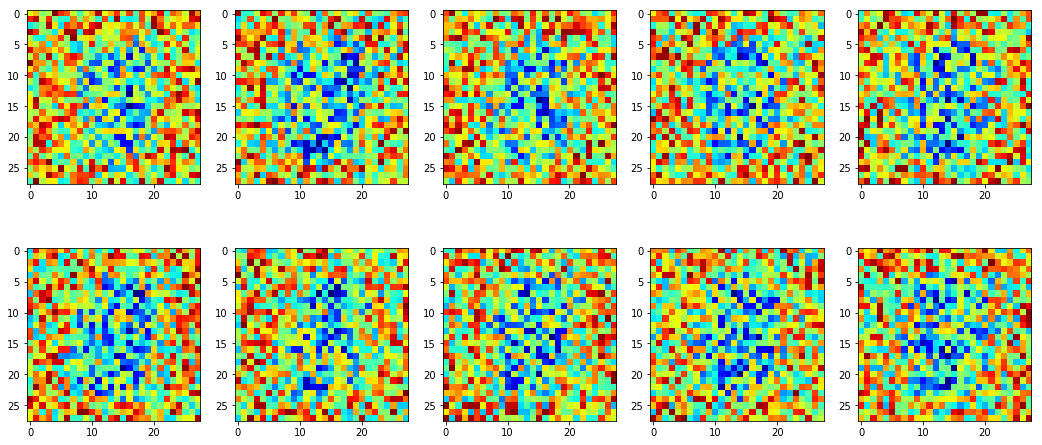

In [139]:
fig = plt.figure(figsize=(18, 8))
for i in range(10):
    weights_pic = weights[i][0:784].reshape(28, 28)
    fig.add_subplot(2, 5, i + 1)
    plt.imshow(weights_pic, cmap='jet')

In [140]:
test_df = pd.read_csv("data/test.csv")

In [141]:
test_df['pixel784'] = 1

In [142]:
test_predictions_df = pd.DataFrame()
for i in range(10):
    test_predictions = predict(test_df.loc[:, 'pixel0':'pixel784'] / 254., weights[i])
    test_predictions_df[i] = pd.Series(test_predictions)

In [143]:
test_predictions_df.index += 1

In [144]:
test_predictions_df

,0,1,2,3,4,5,6,7,8,9
1,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0
10,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0


In [145]:
result = test_predictions_df.idxmax(axis=1)

In [146]:
result.rename('Label', inplace=True)

1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
        ..
27971    0
27972    0
27973    0
27974    0
27975    0
27976    0
27977    0
27978    0
27979    0
27980    0
27981    0
27982    0
27983    0
27984    0
27985    0
27986    0
27987    0
27988    0
27989    0
27990    0
27991    0
27992    0
27993    9
27994    0
27995    0
27996    0
27997    0
27998    0
27999    0
28000    0
Name: Label, Length: 28000, dtype: int64

In [147]:
result.to_csv('data/submission.csv', header=True, index_label='ImageId')